# Mexico-City Acccidental Severity Analysis
### By Cesar Robles

### Installing the python libraries needed for this project
This section could be avoided if the reader previously installed all these libraries. However, it should be a good idea to run this part of the code to warranty the existance of the libraries

In [1]:
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install seaborn
!pip install matplotlib
!pip install altair
!pip install holidays
!pip install statsmodels
!pip install folium

### Reading the database
This part of the code is to read the database named *incidentes-viales-c5.csv*. Nevertheless, this file cannot be uploaded to GitHub due to its size. To solve this problem, a *dataSet_incidentes-viales-c5.zip* was uploaded with all the databases splited by year. Furthemore, to obtain the full database can download from https://datos.cdmx.gob.mx/explore/dataset/incidentes-viales-c5/table/?disjunctive.incidente_c4


In [2]:
# This part of the code is used to read the files in the GitHub folder files, unzip the content and generate
# the file or dataframe
import pandas as pd
import glob
import os

def getDataFile(saving):
    os.system('unzip ./files/dataSet_incidentes-viales-c5.zip')
    files=glob.glob(os.path.join('dataSet_incidentes-viales-c5','*.csv'))

    data = pd.DataFrame()
    for x in files:
        info = pd.read_csv(x)
        data = pd.concat([data,info])

    if saving == 1:
        data.to_csv('./files/incidentes-viales-c5.csv',index=False,encoding='utf-8')
        os.system('rm -r ./dataSet_incidentes-viales-c5')
    return data

files = glob.glob('./files/*')
if not './files/incidentes-viales-c5.csv' in files:
    data = getDataFile(0)
else:
    filePath = './files/incidentes-viales-c5.csv'
    data = pd.read_csv(filePath)

In [3]:
data.head()

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes
0,GA/160123/05714,23/01/2016,22:35:04,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,00:21:08,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,"19.422113,-99.084643",1
1,AO/160123/05826,23/01/2016,22:50:49,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,04:40:37,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,"19.35832,-99.297641",1
2,C4/160124/02187,24/01/2016,09:40:11,Domingo,(N) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,11:13:03,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,"19.21707,-99.21907008",1
3,C4/160124/05723,24/01/2016,22:40:57,Domingo,(N) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,22:55:51,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,"19.32057999,-99.24100992",1
4,C4/160124/01334,24/01/2016,04:25:15,Domingo,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,05:03:59,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,"19.45289997,-99.21587004",1


### Cleaning the database

In [4]:
# Proccess to check all columns with blank elements
def columnListWithBlank(data):
    lista = data.columns.tolist()
    checkList = list()
    for i in lista:
        if len(data[i].isnull().unique()) > 1:
            checkList.append(i)
    return checkList

columnListWithBlank(data)

['delegacion_inicio', 'latitud', 'longitud', 'delegacion_cierre', 'geopoint']

In [5]:
# Check the delegacion_cierre information to retrieve parameter missing
# ej. check parameters in Coyoaccan and retrieve latitud
def validateParameters(parameter):
    delegaciones = data['delegacion_cierre'].drop_duplicates().tolist()
    for delegacion in delegaciones:
        data.loc[(data[parameter].isnull()) & (data['delegacion_cierre'].isin([delegacion])),parameter] = data.loc[(data['delegacion_cierre'].isin([delegacion])),parameter].describe().values[1]
    return data

# Split codigo_cierre column in two columns
splitValues = data['codigo_cierre'].str.split(' ', n=1,expand=True)
splitValues[0] = splitValues[0].str.replace('(','')
splitValues[0] = splitValues[0].str.replace(')','')
data['codigo_cierre_val'] = splitValues[0]
data['codigo_cierre_desc'] = splitValues[1]

# Mark real cases as True and not real case as False
data.loc[(data['codigo_cierre_val'].isin(['A','I'])),'real_case'] = True
data.loc[(~data['codigo_cierre_val'].isin(['A','I'])),'real_case'] = False

# Process to eliminate the blank spaces into delegacion_cierre and delegacion_inicio
data.loc[(data['delegacion_inicio'].isnull()),'delegacion_inicio'] = data['delegacion_inicio'].describe().values[2]
data.loc[(data['delegacion_cierre'].isnull()),'delegacion_cierre'] = data['delegacion_cierre'].describe().values[2]

# fill blank spaces with delegaccion_cierre information
data = validateParameters('latitud')
data = validateParameters('longitud')

# calculate the geopoint based on the latitud and longitud
data['geopoint'] = data['latitud'].astype(str).str.cat(data['longitud'].astype(str), sep =",")

# convert fecha_creacion and fecha_cierre to datetime
data['fecha_creacion'] = pd.to_datetime(data['fecha_creacion'])
data['fecha_cierre'] = pd.to_datetime(data['fecha_cierre'])

In [6]:
data.head()

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,...,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes,codigo_cierre_val,codigo_cierre_desc,real_case
0,GA/160123/05714,2016-01-23,22:35:04,Sábado,(A) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,00:21:08,VENUSTIANO CARRANZA,...,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,"19.422113,-99.084643",1,A,La unidad de atención a emergencias fue despac...,True
1,AO/160123/05826,2016-01-23,22:50:49,Sábado,(A) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,04:40:37,CUAJIMALPA,...,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,"19.358320000000006,-99.297641",1,A,La unidad de atención a emergencias fue despac...,True
2,C4/160124/02187,2016-01-24,09:40:11,Domingo,(N) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,11:13:03,TLALPAN,...,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,"19.21707,-99.21907008",1,N,La unidad de atención a emergencias fue despac...,False
3,C4/160124/05723,2016-01-24,22:40:57,Domingo,(N) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,22:55:51,MAGDALENA CONTRERAS,...,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,"19.32057999,-99.24100992",1,N,La unidad de atención a emergencias fue despac...,False
4,C4/160124/01334,2016-01-24,04:25:15,Domingo,(A) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,05:03:59,MIGUEL HIDALGO,...,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,"19.45289997,-99.21587004",1,A,La unidad de atención a emergencias fue despac...,True


In [7]:
# Checking the columns to avoid any null fields and type
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1355257 entries, 0 to 246576
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   folio               1355257 non-null  object        
 1   fecha_creacion      1355257 non-null  datetime64[ns]
 2   hora_creacion       1355257 non-null  object        
 3   dia_semana          1355257 non-null  object        
 4   codigo_cierre       1355257 non-null  object        
 5   fecha_cierre        1355257 non-null  datetime64[ns]
 6   año_cierre          1355257 non-null  int64         
 7   mes_cierre          1355257 non-null  object        
 8   hora_cierre         1355257 non-null  object        
 9   delegacion_inicio   1355257 non-null  object        
 10  incidente_c4        1355257 non-null  object        
 11  latitud             1355257 non-null  float64       
 12  longitud            1355257 non-null  float64       
 13  clas_con_f_al

In [8]:
# Selecting Accidental Cases
accidents = data.loc[(data['real_case'].isin([True]))]
accidents = accidents.reset_index(drop=True)

In [9]:
accidents['codigo_cierre_val'].values

array(['A', 'A', 'A', ..., 'A', 'A', 'A'], dtype=object)

In [10]:
from sklearn import preprocessing, linear_model, cluster
import seaborn as sns
import matplotlib.pyplot as plt

le_codcie = preprocessing.LabelEncoder()
le_codcie.fit(accidents['codigo_cierre'].values)
accidents['codigo_cierre_encode'] = le_codcie.transform(accidents['codigo_cierre'].values)

le_delini = preprocessing.LabelEncoder()
le_delini.fit(accidents['delegacion_inicio'].values)
accidents['delegacion_inicio_encode'] = le_delini.transform(accidents['delegacion_inicio'].values)

le_inc4 = preprocessing.LabelEncoder()
le_inc4.fit(accidents['incidente_c4'].values)
accidents['incidente_c4_encode'] = le_inc4.transform(accidents['incidente_c4'].values)

le_alarma = preprocessing.LabelEncoder()
le_alarma.fit(accidents['clas_con_f_alarma'].values)
accidents['clas_con_f_alarma_encode'] = le_alarma.transform(accidents['clas_con_f_alarma'].values)

le_tipo = preprocessing.LabelEncoder()
le_tipo.fit(accidents['tipo_entrada'].values)
accidents['tipo_entrada_encode'] = le_tipo.transform(accidents['tipo_entrada'].values)

le_delcie = preprocessing.LabelEncoder()
le_delcie.fit(accidents['delegacion_cierre'].values)
accidents['delegacion_cierre_encode'] = le_delini.transform(accidents['delegacion_cierre'].values)

le_mescie = preprocessing.LabelEncoder()
le_mescie.fit(accidents['mes_cierre'].values)
accidents['mes_cierre_encode'] = le_mescie.transform(accidents['mes_cierre'].values) + 1

In [11]:
accidents.head()

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,...,codigo_cierre_val,codigo_cierre_desc,real_case,codigo_cierre_encode,delegacion_inicio_encode,incidente_c4_encode,clas_con_f_alarma_encode,tipo_entrada_encode,delegacion_cierre_encode,mes_cierre_encode
0,GA/160123/05714,2016-01-23,22:35:04,Sábado,(A) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,00:21:08,VENUSTIANO CARRANZA,...,A,La unidad de atención a emergencias fue despac...,True,0,14,2,1,0,14,4
1,AO/160123/05826,2016-01-23,22:50:49,Sábado,(A) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,04:40:37,CUAJIMALPA,...,A,La unidad de atención a emergencias fue despac...,True,0,4,0,3,0,4,4
2,C4/160124/01334,2016-01-24,04:25:15,Domingo,(A) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,05:03:59,MIGUEL HIDALGO,...,A,La unidad de atención a emergencias fue despac...,True,0,10,2,1,3,10,4
3,GA/160123/05517,2016-01-23,22:02:41,Sábado,(A) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,00:43:50,GUSTAVO A. MADERO,...,A,La unidad de atención a emergencias fue despac...,True,0,6,0,3,0,6,4
4,C4/160124/03357,2016-01-24,14:48:35,Domingo,(A) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,18:48:28,VENUSTIANO CARRANZA,...,A,La unidad de atención a emergencias fue despac...,True,0,14,0,3,5,14,4


<AxesSubplot:xlabel='mes', ylabel='folio'>

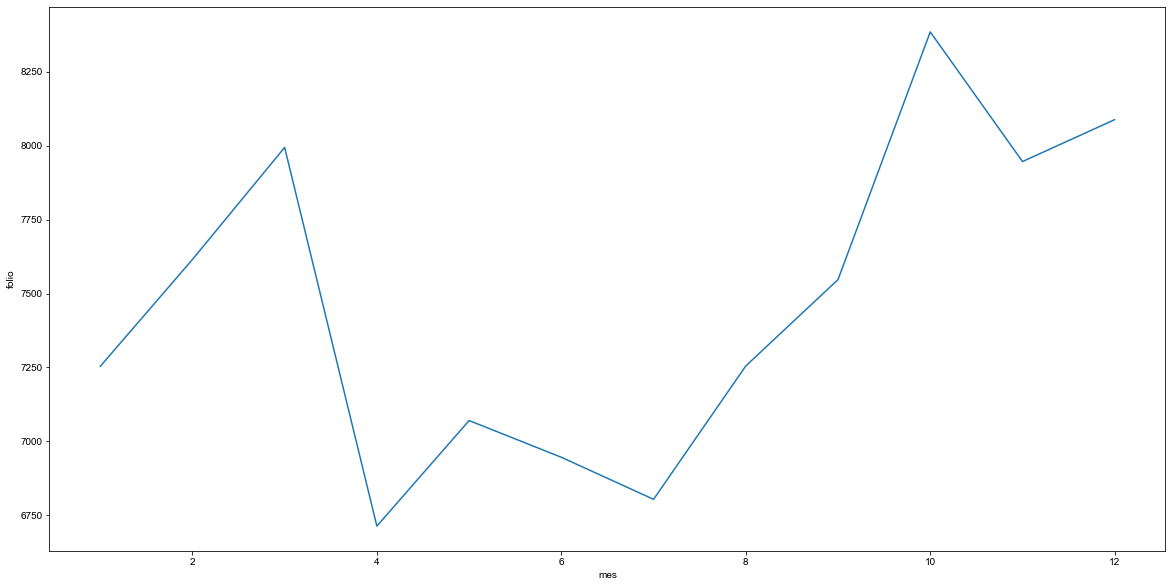

In [12]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
sns.set(font_scale=3)
sns.lineplot(data=accidents.groupby(['mes','mes_cierre','año_cierre'])['folio'].count().reset_index().groupby(['mes','mes_cierre'])['folio'].mean().reset_index(), x='mes', y='folio', ax=ax)

In [13]:
result = accidents.groupby(['mes','mes_cierre','año_cierre'])['folio'].count().reset_index().groupby(['mes','mes_cierre'])['folio'].mean().reset_index()

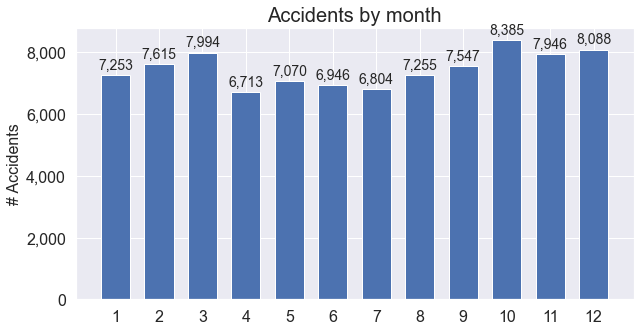

In [14]:
import numpy as np
from matplotlib.ticker import StrMethodFormatter # use method formatter

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=14)

labels = result['mes'].drop_duplicates().tolist()
means = result['folio'].drop_duplicates().tolist()
width = 0.6

[fig,ax]=plt.subplots(figsize=(10,5))
x = np.arange(len(labels))
rects1 = ax.bar(x,means,width+0.07)

ax.set_ylabel('# Accidents',fontsize=16)
ax.set_title('Accidents by month',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=16)

autolabel(rects1)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tick_params(labelsize=16)

<AxesSubplot:xlabel='creacion_day_name', ylabel='folio'>

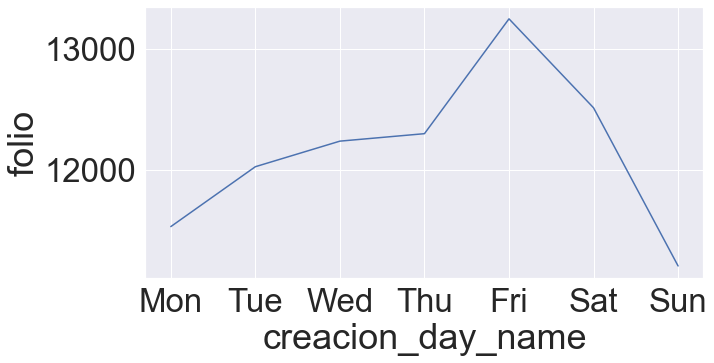

In [15]:
accidents['creacion_day_cde'] = accidents['fecha_creacion'].apply(lambda x : x.dayofweek)
accidents.loc[(accidents['creacion_day_cde']==0),'creacion_day_name'] = 'Mon'
accidents.loc[(accidents['creacion_day_cde']==1),'creacion_day_name'] = 'Tue'
accidents.loc[(accidents['creacion_day_cde']==2),'creacion_day_name'] = 'Wed'
accidents.loc[(accidents['creacion_day_cde']==3),'creacion_day_name'] = 'Thu'
accidents.loc[(accidents['creacion_day_cde']==4),'creacion_day_name'] = 'Fri'
accidents.loc[(accidents['creacion_day_cde']==5),'creacion_day_name'] = 'Sat'
accidents.loc[(accidents['creacion_day_cde']==6),'creacion_day_name'] = 'Sun'
group_dayname_creacion = accidents.groupby(['creacion_day_name','año_cierre'])['folio'].count().reset_index().groupby('creacion_day_name')['folio'].mean().reset_index()
group_dayname_creacion['creacion_day_name'] = pd.Categorical(group_dayname_creacion['creacion_day_name'],categories=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
group_dayname_creacion = group_dayname_creacion.sort_values(by=(['creacion_day_name']))
[fig,ax]=plt.subplots(figsize=(10,5))
sns.set(font_scale=3)
sns.lineplot(data=group_dayname_creacion.sort_values(by='creacion_day_name'), x='creacion_day_name', y='folio')

<AxesSubplot:xlabel='num_hora_creacion', ylabel='folio'>

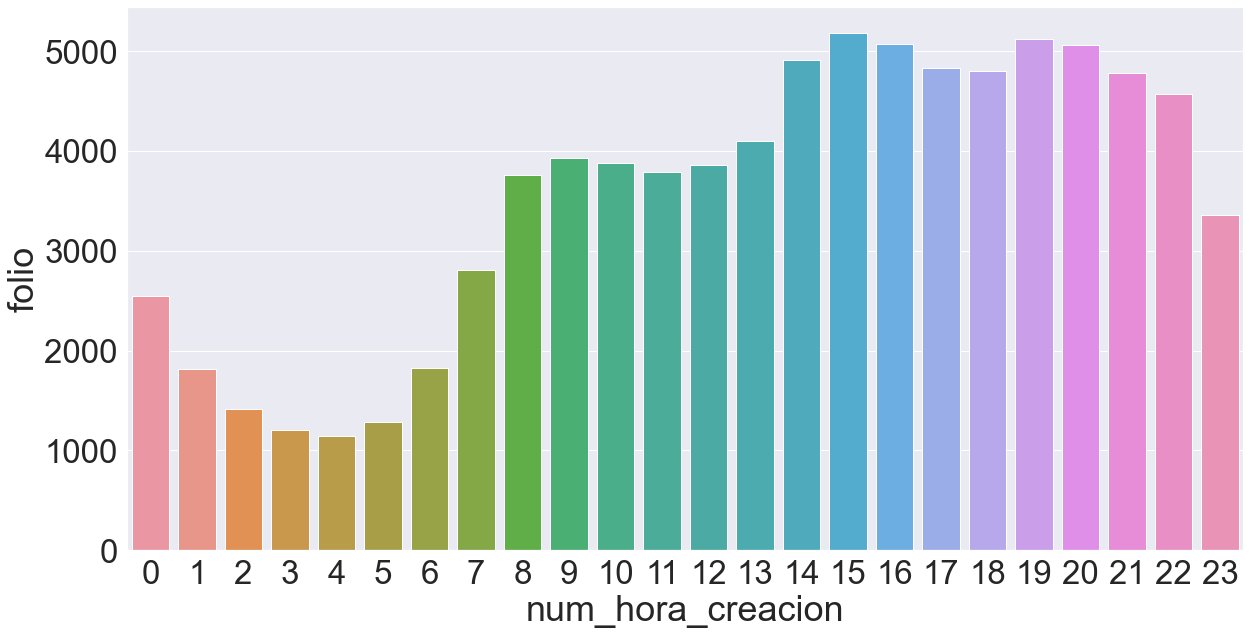

In [16]:
accidents['num_hora_creacion'] = accidents['hora_creacion'].str.split(':', n=2,expand=True)[0]
accidents['num_hora_creacion']=accidents['num_hora_creacion'].astype(float).astype(int)
[fig,ax]=plt.subplots(figsize=(20,10))
sns.set(font_scale=3)
sns.barplot(data=accidents.groupby(['num_hora_creacion','año_cierre'])['folio'].count().reset_index().groupby('num_hora_creacion')['folio'].mean().reset_index(), 
            x='num_hora_creacion', y='folio')

In [17]:
import holidays
mx_holidays = holidays.Mexico()
accidents['is_holiday'] = accidents['fecha_creacion'].apply(lambda x: mx_holidays.get(x))
accidents.head()

le_ho = preprocessing.LabelEncoder()
accidents.loc[~accidents.is_holiday.isnull(),'is_holiday_encoded'] = le_ho.fit_transform(accidents[~accidents.is_holiday.isnull()].is_holiday)

<AxesSubplot:xlabel='folio', ylabel='is_holiday'>

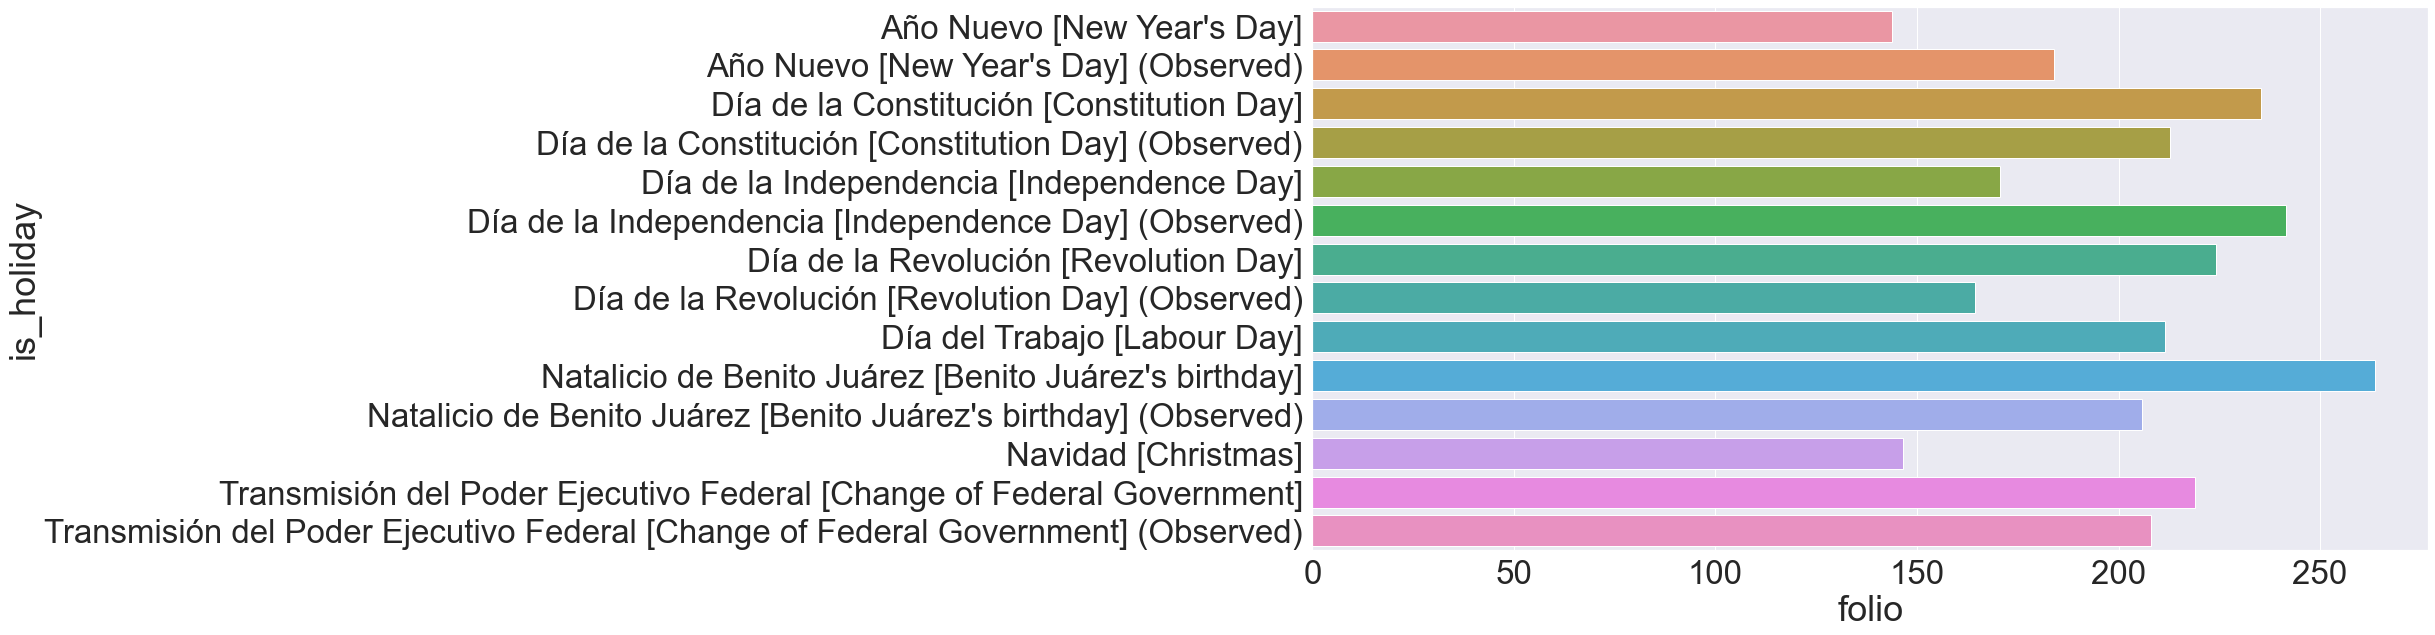

In [18]:
[fig,ax]=plt.subplots(figsize=(20,10))
sns.set(font_scale=3)
sns.barplot(data=accidents.groupby(['is_holiday','año_cierre']).folio.count().reset_index().groupby('is_holiday').folio.mean().reset_index(),
            x='folio',y='is_holiday')

In [19]:
import statsmodels.api as sm
obj = sm.tsa.seasonal_decompose(accidents.groupby('fecha_creacion')['folio'].count(), period=365)

Text(0.5, 1.0, 'Trend')

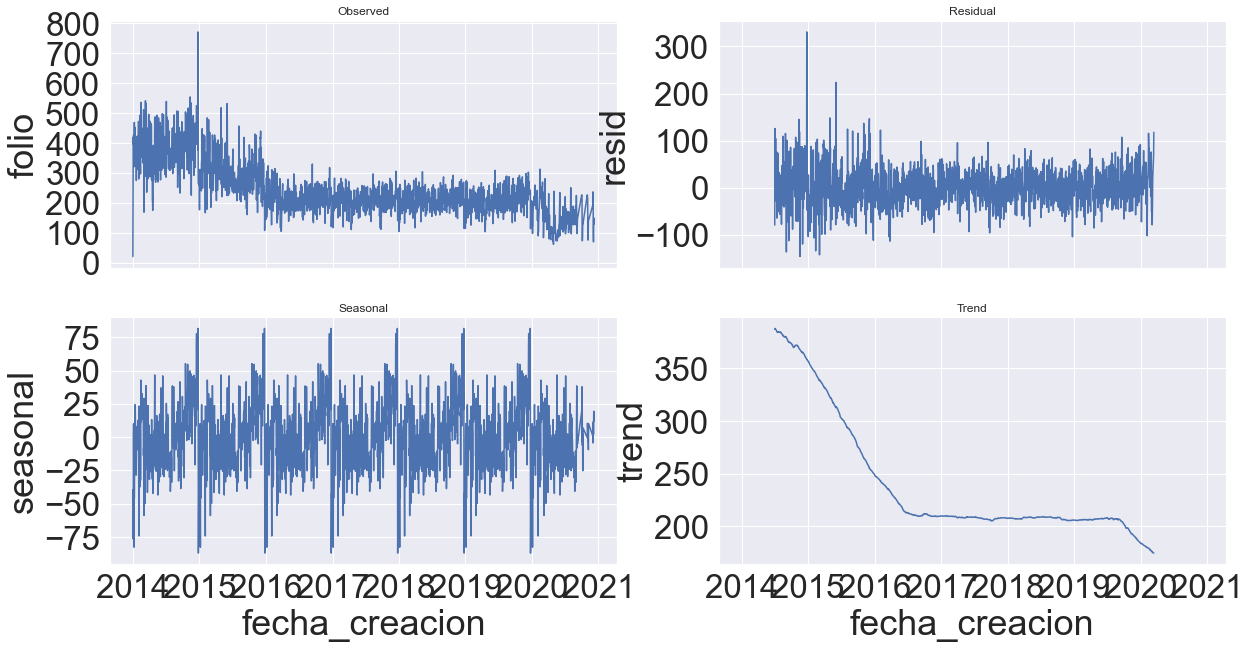

In [20]:
_,ax = plt.subplots(2,2,figsize=(20,10), sharex=True, squeeze=False)
sns.set(font_scale=1)
sns.lineplot(data=obj.observed.reset_index(), x='fecha_creacion', y='folio', ax=ax[0,0])
sns.lineplot(data=obj.resid.reset_index(), x='fecha_creacion', y='resid', ax=ax[0,1])
sns.lineplot(data=obj.seasonal.reset_index(), x='fecha_creacion', y='seasonal', ax=ax[1,0])
sns.lineplot(data=obj.trend.reset_index(), x='fecha_creacion', y='trend', ax=ax[1,1])

ax[0,0].set_title('Observed')
ax[0,1].set_title('Residual')
ax[1,0].set_title('Seasonal')
ax[1,1].set_title('Trend')

In [21]:
#accidents.groupby(['mes','mes_cierre','año_cierre'])['folio'].count().reset_index().groupby(['mes','mes_cierre'])['folio'].mean().reset_index()
result = accidents.groupby(['mes','año_cierre','delegacion_cierre'])['folio'].count().reset_index().groupby(['delegacion_cierre'])['folio'].mean().reset_index()
result = result.sort_values(by=['folio'],ascending=False)

In [22]:
alcaldias = data['delegacion_cierre'].drop_duplicates().tolist()
alcaldias.sort()
latitud = list()
longitud = list()
for alcaldia in alcaldias:
    latitud.append(data.loc[(data['delegacion_cierre'].isin([alcaldia])),['latitud','longitud']].mean().values[0])
    longitud.append(data.loc[(data['delegacion_cierre'].isin([alcaldia])),['latitud','longitud']].mean().values[1])

d = {'delegacion_cierre':alcaldias,'latitud':latitud,'longitud':longitud}
alcaldias = pd.DataFrame(data = d)
result = result.merge(alcaldias,how='left',on=['delegacion_cierre'])

In [23]:
result

,delegacion_cierre,folio,latitud,longitud
0,IZTAPALAPA,1081.0000,19.354489,-99.071076
1,CUAUHTEMOC,887.8250,19.429826,-99.169282
2,GUSTAVO A. MADERO,829.8375,19.489614,-99.115218
3,MIGUEL HIDALGO,635.3750,19.429472,-99.195110
4,BENITO JUAREZ,612.4250,19.382742,-99.163102
5,COYOACAN,563.7625,19.327321,-99.149133
6,ALVARO OBREGON,524.1250,19.360857,-99.215477
7,VENUSTIANO CARRANZA,515.5000,19.427970,-99.100901
8,TLALPAN,456.6375,19.275854,-99.174970
9,IZTACALCO,339.1875,19.398283,-99.105279


In [24]:
import folium
m = folium.Map(location=[19.42847, -99.12766],zoom_start=12)

In [34]:
def markers(m, data):
    for index, rows in data.iterrows():
        tooltip=rows['delegacion_cierre']
        folium.Marker([rows['latitud'],rows['longitud']],popup='<i>'+rows['delegacion_cierre']+'</i><br>Average crimes: <b>'+str(rows['folio'])+'</b>',tooltip=tooltip).add_to(m)
    return m

m = markers(m,result)

In [35]:
m

End!